## Passion Fruits, Object detection and localization model

In [71]:
import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

### Read the csv files

### Train

In [72]:
train_df = pd.read_csv('Train.csv')
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [73]:
train_df.shape

(3906, 6)

In [74]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(3001, 6)


We have 3906 bounding boxes, from a collection of 3001 images. Some images have 1 bounding box, while others have more than 1 bounding box.

### Test

In [75]:
test_df = pd.read_csv("Test.csv")
test_df.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [76]:
test_df.shape

(931, 1)

In [79]:
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']

In [80]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height,xmax,ymax
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,315.0,398.5
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,342.5,372.0
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,404.5,512.0
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,379.5,410.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,313.0,414.5


- Encode the classes from str to int

In [81]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [82]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height,xmax,ymax
0,ID_007FAIEI,3,87.0,87.5,228.0,311.0,315.0,398.5
1,ID_00G8K1V3,1,97.5,17.5,245.0,354.5,342.5,372.0
2,ID_00WROUT9,1,156.5,209.5,248.0,302.5,404.5,512.0
3,ID_00ZJEEK3,2,125.0,193.0,254.5,217.0,379.5,410.0
4,ID_018UIENR,1,79.5,232.5,233.5,182.0,313.0,414.5


In [83]:
df = train_df.copy() # create a copy of the train df

In [84]:
path = 'Train_Images/'

In [85]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [86]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


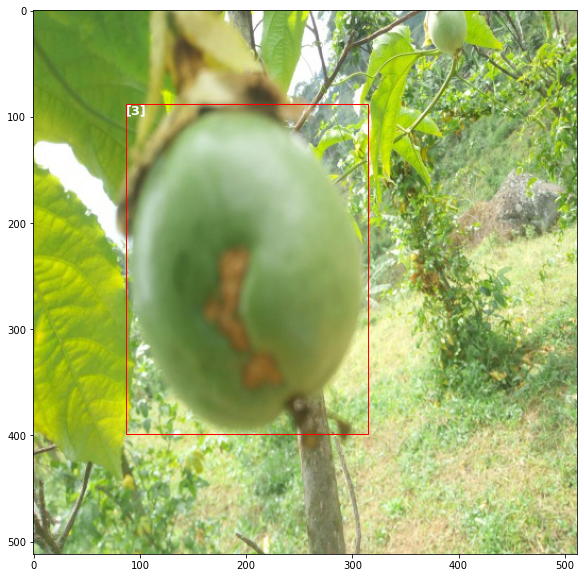

In [87]:
name = df.Image_ID.unique()[0]
plot_image(name)

      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5
      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5


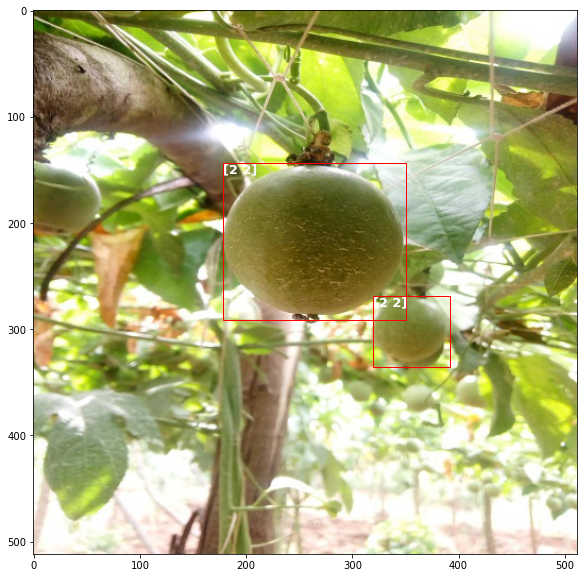

In [88]:
name = df.Image_ID.unique()[700]
plot_image(name)

     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0
     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0


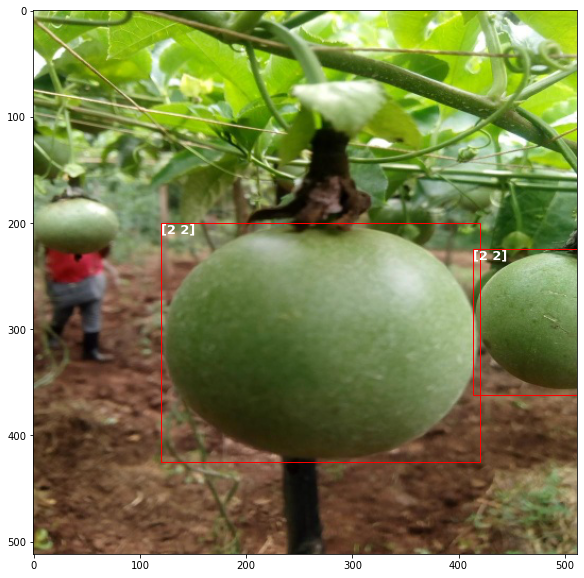

In [89]:
name = df.Image_ID.unique()[67]
plot_image(name)

In [90]:
class PassionFruit(object):
    def __init__(self, df, IMG_DIR, transforms): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

In [91]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [92]:
passion_dataset = PassionFruit(df, path, get_train_transform())

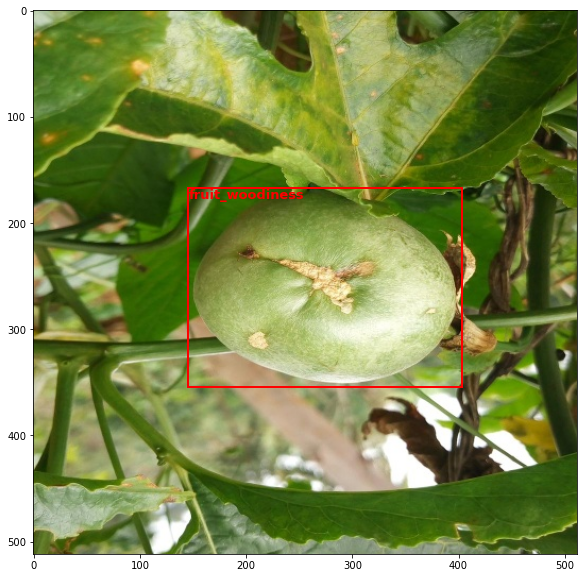

In [93]:
img, tar, _ = passion_dataset[random.randint(0,1000)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"fruit_brownspot",  2:"fruit_healthy", 3:"fruit_woodiness"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

#### Split data into training and test

In [94]:
image_ids = df['Image_ID'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['Image_ID'].isin(valid_ids)]
train_df = df[df['Image_ID'].isin(train_ids)]
train_df.shape,valid_df.shape

((3054, 8), (852, 8))

In [95]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PassionFruit(df, path, get_train_transform())
valid_dataset = PassionFruit(df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [96]:
num_classes = 4  # + background

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [97]:
device = torch.device('cpu') # if torch.cuda.is_available() else torch.device('cpu')

In [98]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [99]:
num_epochs = 2